# ASSIGNMENT 4: Animal Classification of Images using Neural Network and CNN

In this assignment we have a data collection of 28000 images belonging to ten different classes. In the first part, using these images of animals as training data, we will attempt to build a neural network. As a consequence of our research, we will first attempt to classify using a single layer neural network, then compare the results by attempting to classify using a multilayer neural network. We will next try to decide which structure is the most appropriate for animal categorization. Similary, in the second part, we will classify animal images by using CNN with VGG-19.

## PART 1: Neural Network

A neural network is made up of many processors that function in parallel and are grouped in tiers. The raw input information is received by the first tier, which functions similarly to the optic neurons in human visual processing. In the same manner that neurons further away from the optic nerve receive signals from those closer to it, each succeeding tier receives the output from the layer before it rather than the raw input. The system's output is produced by the last tier. Each processing node has its own sphere of knowledge, which includes what it has seen as well as any rules it was programmed with or created for itself.

Neural networks are known for being adaptable, which means they change as they learn from their initial training and deliver more information about the world in subsequent runs. Weighting the input streams, which is how each node weights the relevance of information from each of its predecessors, is the simplest fundamental learning model. Inputs that help you get the right responses are given more weight.

Unlike other algorithms, neural networks cannot be explicitly programmed for the task due to their deep learning. Rather, they are required to learn the material, much as a child's developing brain is required to learn. There are three types of learning strategies: supervised, unsupervised and reinforced learning. In this assignment we will use supervised learning method. This technique in supervised learning is the simplest, as it involves the computer going through a labeled dataset and modifying the algorithm until it can analyze the dataset and produce the intended result.

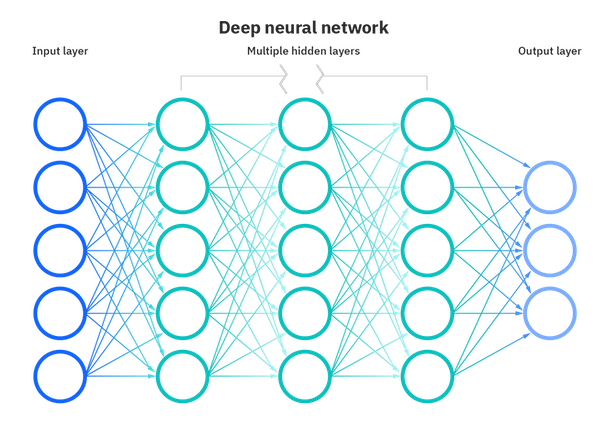

As can be seen from the figure above, a neural network consists of an input layer, zero or more hidden layers and an output layer. In our case, we will first resize the given images, convert them to pixels and flatten them. Thus, our input layer will consist of the number of pixels in our images. Moreover, since we have 10 different classes which are cane, cavallo, elefante, farfalla, gallina, gatto, mucca, pecaro, ragno and scoiattollo, the number of neurons in the output layer will be 10. 

In this assignment, we will test our algorithm on single layer network firstly (only input and output layer), then with one hidden layer and lastly with two hidden layers (multi layer neural network).

Each network neuron (excluding those in the input layer) is made up of the total of all its inputs, which are the previous layer's outputs multiplied by some weights. This total is then multiplied by a bias term. The result is then subjected to a nonlinear function known as the activation function. These numerical values (weights, bias) are exactly what we'll strive to change by training the network with a pre-labeled dataset. After we initialize the parameters, we’ll proceed iteratively by following an optimization algorithm that will try to minimize the difference between the actual output and the one estimated by the network

If we think in general, what we do in this assignment is that we will first feed input data into the neural network, then the data flows from one layer to another until we obtain an output. Once we have the output, we can calculate the error, finally, we will change a parameter's weight or bias by removing the error's derivative with respect to the parameter. We will iterate through the process and train the neural network then calculate the accuracy and analyze results obtained.

The neural network algorithm determines the parameters (weights and biases) by applying forward propagation and backpropagation. Forward and backward propagation are interdependent when training neural networks. Forward propagation, in particular, traverses the computational network in the direction of dependence, computing all variables along the way. These are then used for backpropagation, which reverses the graph's compute order.

Some images from the given dataset can be seen below.

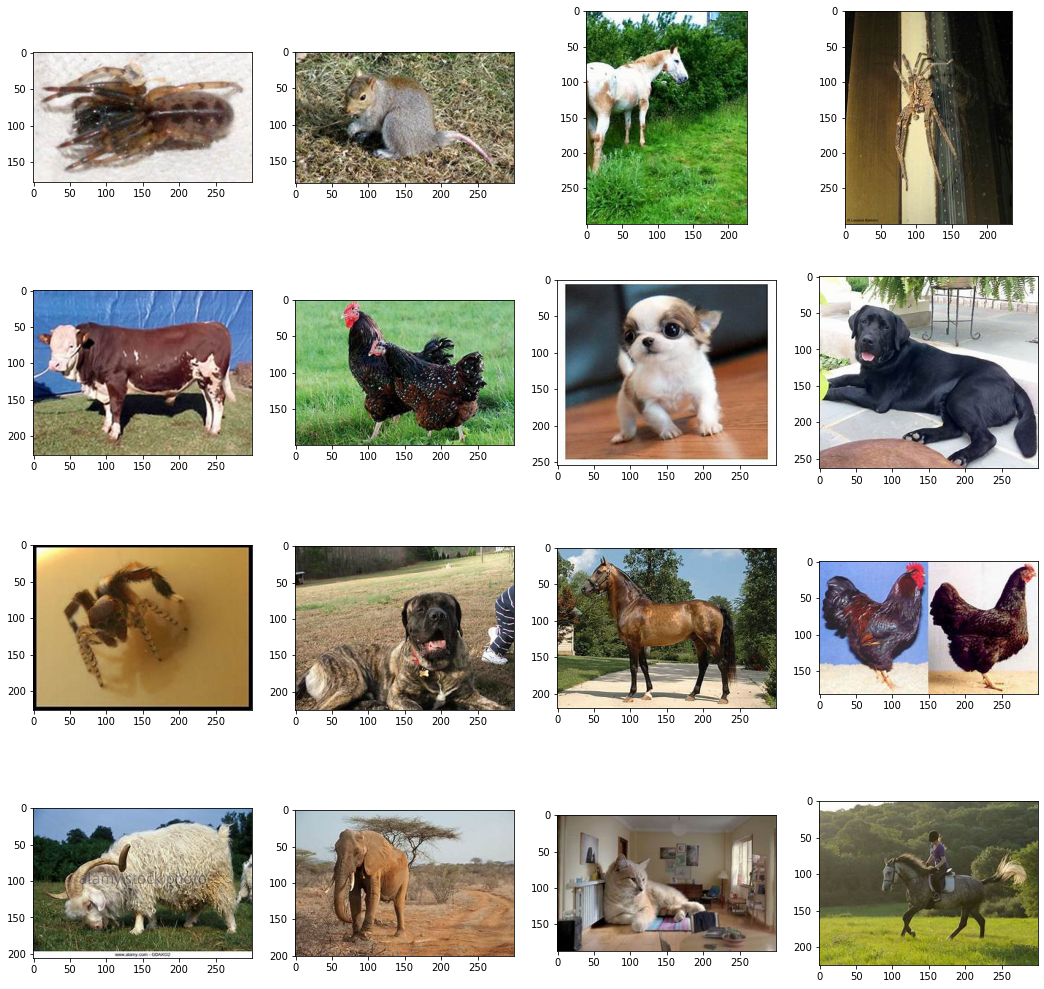

In [61]:
dataset = Dataset()
w=10
h=10
fig=plt.figure(figsize=(18, 18))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    r = np.random.randint(len(dataset))
    img = dataset.get_image(r)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Code Implementations

In [38]:
import os
import pickle

import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt

In [44]:
class Dataset:
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
        "dog": "cane",
        "horse": "cavallo",
        "elephant" : "elefante",
        "butterfly": "farfalla",
        "chicken": "gallina",
        "cat": "gatto",
        "cow": "mucca",
        "sheep": "pecora",
        "spider": "ragno",
        "squirrel": "scoiattolo"
    }

    def __init__(self, data_parent='data/'):
        super().__init__()

        self.data_path = os.path.join(data_parent, 'raw-img')

        self.org_names = list(self.translate.keys())[:10]
        self.eng_names = list(self.translate.keys())[10:]

        self.data_paths = []
        for i in range(len(self.org_names)):
            img_paths = glob(
                os.path.join(self.data_path, self.org_names[i], '*')
            )
            
            self.data_paths.extend(list(zip(img_paths, [i] * len(img_paths))))
        
        self.mean = 0.459
        self.var = 0.269

    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        img_path, label = self.data_paths[index]
        img = Image.open(img_path).convert('L').resize((64, 64))
        img_arr = np.asarray(img)
        img_arr = img_arr / 255
        img_arr = (img_arr - self.mean) / self.var
        img_arr = img_arr.flatten()

        return img_arr, label
    
    def get_image(self, index):
        img_path, label = self.data_paths[index]
        return Image.open(img_path)

    def getlabel(self, index):
        return self.data_paths[index][1]


In order to train our algortihm properly, it is required to preprocess our animal images dataset. Dataset class first loads images from the "raw_img" folder and loads path to "data_path" field. __getitem__ function takes an index, loads that particular image, resizes it to 64x64, converts the pixel values to its grayscale values, flatten the array and returns it. Since images may have different height and weight values, it is necessary to resize them to a particular value because we feed the algorithm on the first layer with the fixed number of pixel's grayscale values, in this case 4096 total neurons in the first layer. 

In [16]:
def fully_connected(X, params):
    W, b = params

    out = (X @ W) + b
    dx = W
    dw = X
    db = np.ones_like(out)  # Not used

    return {'out': out, 'dx': dx, 'dw': dw, 'db': db}

### Train and Test

In [20]:
def test(network, dataset, test_set, batch_size, epoch):
    iter_count = len(test_set) // batch_size

    data_index = 0
    epoch_tqdm = tqdm(
        range(iter_count), total=iter_count, leave=True, desc=f"Test {epoch}"
    )

    targets = []
    predictions = []
    for iter in epoch_tqdm:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = dataset[train_set[data_index]]
            X.append(x)
            Y.append(y)
            data_index += 1
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        output_of_previous_layer = X

        for f in network:
            if f == softmax_nll_eval:
                y = f(output_of_previous_layer, None)
            else:
                y = f[0](output_of_previous_layer, f[1])
            output_of_previous_layer = y['out']

        predictions.extend(y['out'])
        targets.extend(Y)
    
    return np.asarray(targets), np.asarray(predictions)

First of all, we calculate the number of iterations by diving test size to batch size. Then, we iterate over the test data and for the current test data, we invoke __softmax_nll_eval__ function and obtain the prediction of the model, add new prediction to y["out]. We return real values and our predictions from this function.

In [21]:
def train_one_epoch(network, dataset, train_set, lr, batch_size, epoch):
    iter_count = len(train_set) // batch_size
    
    loss_vals = []

    data_index = 0
    epoch_tqdm = tqdm(
        range(iter_count), total=iter_count, leave=True, desc=f"Train {epoch}:"
    )
    for iter in epoch_tqdm:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = dataset[train_set[data_index]]
            X.append(x)
            Y.append(y)
            data_index += 1
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        output_of_previous_layer = X

        out_list = []
        for f in network:
            if f == softmax_nll:
                y = f(output_of_previous_layer, Y)
            else:
                y = f[0](output_of_previous_layer, f[1])
            out_list.append(y)
            output_of_previous_layer = y['out']

        loss_vals.append(y['out'])

        dout = out_list[-1]['dx']
        for i in range(len(network)-2, -1, -1):
            if network[i][0] == fully_connected:
                network[i][1][0] = (
                    network[i][1][0] - lr * out_list[i]['dw'].T @ dout
                )
                network[i][1][1] = (
                    network[i][1][1] - lr * np.sum(dout, axis=0, keepdims=True)
                )

                dout = dout @ out_list[i]['dx'].T
            
            elif network[i][0] == LRelu:
                dout = dout * out_list[i]['dx']

    return network, loss_vals


After calculating the iter_count, we obtain dataset items in the number of batchsize and store them in X and Y variables. Inside the __softmax_nll__ we compute loss and apply gradient descent. So, y["out"] returns the loss value calculated and y["dx"] returns the derivative for gradient descent. Then, we iterate over the network and update weights and biases. Ultimately, we return loss values and the network.

### Forward Propagation

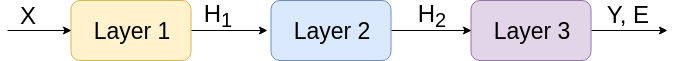

The input data is fed in the forward direction across the network, as the name implies. Each hidden layer accepts data, processes it according to the activation function, and then sends it on to the next layer. The output of each layer becomes the input of the following layer until we reach the network's finish. We may calculate an error E by comparing the network's output with the desired output. The goal is to reduce the error by altering the network's parameters. This is known as reverse propagation (backpropagation)

### Backpropagation

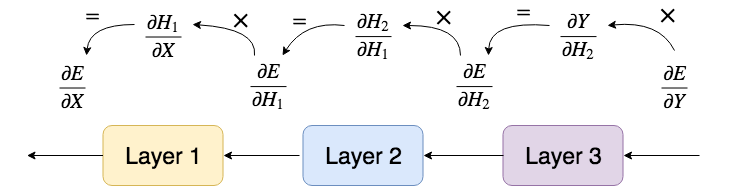

The process of computing the gradient of neural network parameters is known as backpropagation. In a nutshell, the method follows the chain rule from calculus to traverse the network in reverse order, from the output to the input layer.

The partial derivatives of the loss function with respect to the parameters of the last layer, which have no influence over any other network parameters, are calculated first by backpropagation. Because of the chain rule, this is a simple computation. After obtaining these derivatives, we proceed to the previous layer and compute the partial derivatives of the loss function, but this time with regard to the parameters of this layer, which we have partially solved owing to the chain rule. 

The implementation is similar to forward propagation but this time we calculate the derivatives. And used $alpha$ to determine the learning rate.

### Activation Functions

In [17]:
def LRelu(X, a):
    out = np.where(X<0, X*a, X)

    # Derivative for Gradient Descent
    dx = np.where(X<0, a, 1)

    return {'out': out, 'dx': dx}

In a neural network, an activation function specifies how the weighted sum of the input is turned into an output from a node or nodes in a layer. The activation function chosen has a significant impact on the neural network's capabilities and performance, and different activation functions may be utilized in different portions of the model.

A neural network's activation function is an essential component. A neural network is a simple linear regression model without an activation function. This suggests that the activation function gives the neural network non-linearity.

Activation functions we used:
- "sigmoid" : The function accepts any real value as input and returns a value between 0 and 1. The larger the input (more positive), the closer the output to 1.0, and the smaller the input (more negative), the closer the output to 0.0. We utilize the sigmoid function since it exists between two points (0 to 1). As a result, it is particularly useful in models where the probability must be predicted as an output. Because the likelihood of anything only occurs between 0 and 1, sigmoid is a good option.
- "ReLu" : The rectified linear activation unit, or ReLU, is one of the few landmarks in the deep learning revolution. It's simple, yet it's far superior to previous activation functions like sigmoid or tanh. Both the ReLU function and its derivative are monotonic. If the function receives any negative input, it returns 0; however, if the function receives any positive value x, it returns that value. As a result, the output has a range of 0 to infinite.

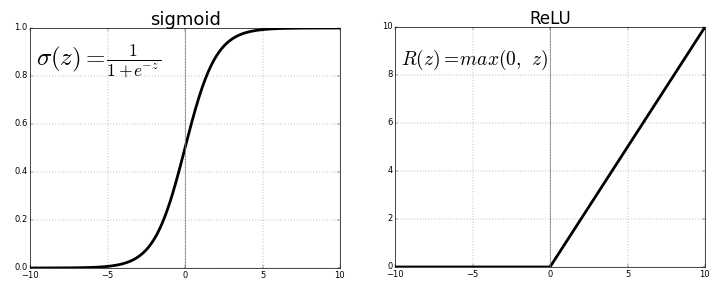

### Gradient Descent

In general, the gradient is a numeric calculation allowing us to know how to adjust the parameters of a network in such a way that its output deviation is minimized. The algorithm has several versions depending on the number of samples that we introduce to the network for each iteration, which are batch, stochastic and mini batch. We use mini batch with learning range in the range of (0.005 - 0.2) and batch size of (16-128) in this assignment.

Choosing the appropricate learning rate is an important issue because a small learning rate requires many updates before reaching the minimum point whereas too large of learning rate causes drastic updates which lead to divergent behaviours.

Instead of feeding the network with single data, mini-batch gradient descent introduces N random objects each iteration. This maintains the benefits of the previous version while additionally allowing for faster training due to parallelization of operations. This version of the method will be used, with N set to a value that strikes a suitable balance between unpredictability and training time.

We'll update the network parameters by subtracting the corresponding gradient value from their current values, multiplied by a learning rate that allows us to change the size of our steps, once we've gotten the gradient vector. Because we want to travel in the opposite direction of the gradient, lowering the loss value, the update term is subtracted.

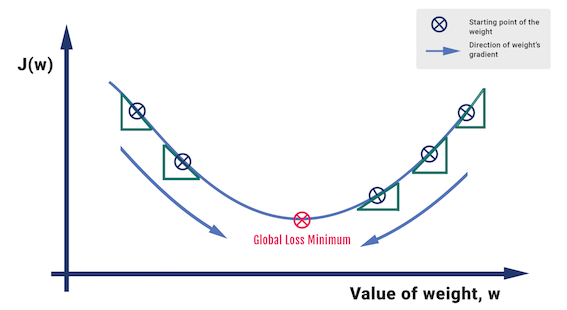

### Loss Function

To reduce algorithmic error, neural networks employ optimization algorithms such as stochastic gradient descent. A Loss Function is used to calculate this error. It's used to determine how well or poorly the model is performing. Before applying gradient descent, we calculate the loss function and then update network parameters w and b to minimize the loss function using gradient descent algorithm.

### Softmax

In [18]:
def softmax_nll(X, Y):
    # Extract max for numerical stability.
    x_max = np.max(X, axis=1, keepdims=True)

    # Unstable
    # e_x = np.exp(X - x_max)
    # probs = e_x / np.sum(e_x, axis=1, keepdims=True)

    log_e_x = np.log(np.sum(np.exp(X - x_max), axis=1, keepdims=True))
    log_probs = X - x_max - log_e_x
    
    # Compute loss
    N = X.shape[0]
    out = -np.sum(log_probs[np.arange(N), Y]) / N
    
    # Derivative for Gradient Descent
    dx = np.exp(log_probs)
    dx[np.arange(N), Y] = dx[np.arange(N), Y] - 1
    dx = dx/N

    return {'out': out, 'dx': dx}

In this function, first of all we extract the max value, then compute loss and after that we apply gradient descent algorithm. As mentioned before, loss is calculated to understand how well our model is performing. So, we first calculate the loss value and then apply gradient descent. This function returns the loss value and the derivate for gradient descent.

In [19]:
def softmax_nll_eval(X, Y):
    # Extract mean for numerical stability.
    x_max = np.max(X, axis=1, keepdims=True)

    # Unstable
    # e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
    # probs = e_x / np.sum(e_x,axis=1, keepdims=True)

    log_e_x = np.log(np.sum(np.exp(X - x_max), axis=1, keepdims=True))
    log_probs = X - x_max - log_e_x

    return {'out': np.argmax(log_probs, axis=1)}

This function calculates the evaluation for the softmax layer. It receives a X parameter, calculate the max, then carries out necesssary calculations and produces the output.

Softmax function takes an N-dimensional vector of real numbers and transforms
it into a vector of real number in range $( 0,1 )$ which add upto $ p _ { i } = \frac { e ^ { a _ { i } } } { \sum _ { k = 1 } ^ { N } e _ { k } ^ { a } }$

This property of softmax function that it outputs a probability distribution makes it suitable for probabilistic interpretation in classification tasks.

Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer. So, we have 10 nodes in the softmax layer.

Softmax takes the concept of logistic regression and applies it to a multi-class world. In a multi-class problem, Softmax assigns decimal probabilities to each class. The sum of those decimal probabilities must equal 1.0. This added constraint allows training to converge faster than it would without.

### Main Function

In [11]:
def neural_network():
    file = open('results2.txt', 'w')
    global best_of_best_network
    np.random.seed(123)
    batch_size = 16
    dataset = Dataset()

    test_set_size = len(dataset)//10
    train_set_size = len(dataset)-test_set_size

    indices = np.arange(len(dataset))
    indices = np.random.permutation(indices)

    train_set = indices[:train_set_size]
    test_set = indices[train_set_size:]

    # Discard last batch if not compatible with batch size
    test_set_size = (test_set_size // batch_size) * batch_size
    train_set_size = (train_set_size // batch_size) * batch_size
    train_set = indices[:train_set_size]
    test_set = indices[:test_set_size]

    model_name = 'mlnn.pth'
    is_train = False

    # Number of units in network
    neurons_list = [[4096, 10], [4096, 1024, 10], [4096, 1024, 256, 10]]
    batch_sizes = [16, 32, 64, 128]
    lrs = [0.005, 0.01, 0.02]
    #lr = 0.01

    best_of_best_acc = -100
    for neurons in neurons_list: # 3
        for batch_size in batch_sizes: # 4
            for lr in lrs: # 3
                # Create model
                xav_lim = 1 / np.sqrt(neurons[0])
                network = []
                for i in range(1, len(neurons)):
                    network.append([
                        fully_connected,
                        [  # Xavier initialization: [-1/sqrt_inp_neur, 1/sqrt_inp_neur]
                            np.random.rand(
                                neurons[i-1], neurons[i]
                            ) * 2 * xav_lim - xav_lim,  # Weights
                            np.zeros((1, neurons[i]))  # Biases
                        ]
                    ])

                    if i != len(neurons) - 1:
                        network.append([LRelu, 0.1])
                    else:
                        network.append(softmax_nll)

                # Training loop
                best_network = []
                best_acc = -100
                full_loss_vals = []
                for epoch in range(1, 10+1):
                    file.write("\n------------------------------------------------------------\n")
                    file.write("Neurons: {}, Batch Size: {}, Learning Rate: {}, Epoch: {}\n".format(neurons, batch_size, lr, epoch))
                    # Train
                    network[-1] = softmax_nll
                    network, loss_vals = train_one_epoch(
                        network, dataset, train_set, lr, batch_size, epoch
                    )

                    file.write(f"Loss Value: {sum(loss_vals)/len(loss_vals):.2f}%\n")

                    # LR scheduler
                    #lr *= 0.9

                    full_loss_vals.extend(loss_vals)

                    # Eval
                    network[-1] = softmax_nll_eval
                    targets, predictions = test(
                        network, dataset, train_set, batch_size, epoch
                    )

                    train_acc = np.mean(targets == predictions) * 100

                    file.write(f"Train Accuracy: {train_acc:.2f}%\n")

                    if train_acc >= best_acc:
                        best_network = network
                        #pickle.dump(network, open(model_name, 'wb'))
                        best_acc = train_acc
                    if train_acc >= best_of_best_acc:
                        best_of_best_network = network
                        best_of_best_acc = train_acc

                #plt.plot(full_loss_vals)
                #plt.savefig("part1_train_loss_vals.png")

                #model_path = "models/mlnn_2.pth"
                #network = pickle.load(open(model_path, 'rb'))

                # Eval
                best_network[-1] = softmax_nll_eval
                targets, predictions = test(
                    best_network, dataset, test_set, batch_size, "Run"
                )

                conf_mat = np.zeros((10, 10))
                for t, p in zip(targets, predictions):
                    conf_mat[t, p] += 1

                test_acc = np.mean(targets == predictions) * 100
                file.write(f"Accuracy: {test_acc:.2f}%\n")

                file.write("Confusion matrix:\n")
                content = str(conf_mat)
                file.write(content)
                print(conf_mat)

                file.write("\n*******************************************\n")
    file.close()

In the main function of part1, we first create a Dataset() object and a file to save step by step results for each epoch with different parameters. We define test and train data sizes in the ratio of 1/10 so the 10% of total data is seperated for testing. We discard the last batch if not compatible with batch size.

In this assignment, it is asked to compare results with different parameters like batch size, learning rate and number of layers. Therefore, we created different arrays for the parameters we want to test the algorithm with. For batch sizes, we choose 16, 32, 64 and 128 respectively. For learning rates we choose 0.005, 0.01 and 0.02 and finally for the number of neurons in the layers we choose [4096, 10] for the single layer neural network, [4096, 1024, 10] for neural network with only one hidden layer, and [4096, 1024, 256, 10] for neural network with two hidden layers (multi-layer network.)

After that, we created a nested for loop in order to be able to test our algorithms with our predefined parameters. We set up the weight matrices and bias vectors with Xavier initialization. It's crucial to note that we shouldn't set all of the parameters to zero because this will make the gradients equal, the output will be the same on each iteration, and the learning algorithm will not learn anything. The goal of Xavier Initialization is to initialize the weights such that the variance of the activations are the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing.

We first train the algorithm with current parameters, for repeating times of given epoch (chosen as 10). We obtain the loss value for the current epoch and compute the train accuracy and compare the current accuracy with the best accuracy calculated so far for the models created with the same parameters. If the current model has better accuracy then the previous best model, we update the related parameters.

In order to evaluate the model with test data, we run the test data with the best network obtained. Lastly, we produce a confusion matrix and get the accuracy.

It is important here to note that in order to plot line graphs and draw tables, we require lots of results to compare and analyze. Thus, the for loop inside main function of part1 loops over different parameters for multiple epochs (which is 10 in our case). We run the algorithm with the same parameters for 10 epoch and save the results for each of them. The graphs and tables we obtained for illustration and analysis can be seen on the upcoming chapter.

### Results Interpretation and Visualization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
def draw_table(data, column_labels, row_labels, title, subtitle, color):
    fig, ax =plt.subplots(1,1)
    df=pd.DataFrame(data,columns=column_labels)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values,
            colLabels=df.columns,
            rowLabels=row_labels,
            rowColours =[color] * len(row_labels),  
            colColours =[color] * len(column_labels),
            loc="center")
    table.scale(1, 2)
    table.set_fontsize(16)
    ax.axis('off')
    title = title
    subtitle = subtitle
    ax.set_title(f'{title}\n({subtitle})', weight='bold', size=14, color='k')


    plt.show()

### Batch Size

In [23]:
from matplotlib import pyplot as plt
def plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, layer, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    plt.suptitle("Graph for Average Loss and Accuracy" + "\n" + "With Learning Rate: 0.01" + "\n" + layer)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_16, color="blue", label="Batch Size: 16", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_32, color="red", label="Batch Size: 32", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_64, color="green", label="Batch Size: 64", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_128, color="orange", label="Batch Size: 128", linewidth=1, linestyle="-")



    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_16, color="blue", label="Batch Size: 16", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_32, color="red", label="Batch Size: 32", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_64, color="green", label="Batch Size: 64", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_128, color="orange", label="Batch Size: 128", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+layer+lr+".png")
    #plt.close()

We can not pass the whole dataset into our model to train it, so we split the dataset into batches, instead of training the model on whole in a single phase. The main reason we use batch is that the backpropagation process slows down the learning process. When we use batch you get speed, but noise may be a bad thing. 

The graphs below illustrate the average train loss and train accuracy results for different batch sizes (16, 32, 64, 128) with respect to different neural network structures like single layer and multilayer neural networks. The goal is to observe the effect of batch size on our models. The first thing that stands out is that in a single layer neural network, the average loss decreases as the number of batch increases. Train accuracy is higher in one hidden layer and two hidden layers architecture neural network than single layer architecture. In single layer architecture, the accuracy has reached 65% while the batch size is equal to 16. We see that the accuracy decreases as the batch size increases.

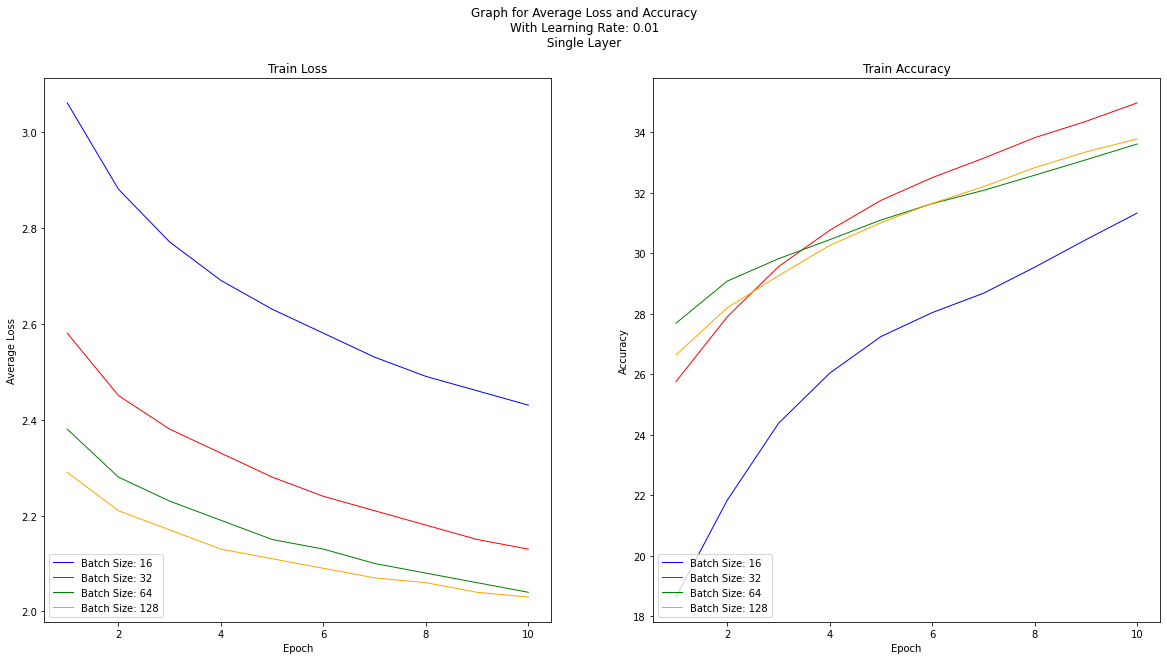

In [26]:
#lr = 0.01, Neurons: [4096, 10]
loss_16 = [3.06, 2.88, 2.77, 2.69, 2.63, 2.58, 2.53, 2.49, 2.46, 2.43]
acc_16 = [18.64, 21.84, 24.38, 26.04, 27.25, 28.04, 28.68, 29.54, 30.45, 31.33]

loss_32 = [2.58, 2.45, 2.38, 2.33, 2.28, 2.24, 2.21, 2.18, 2.15, 2.13]
acc_32 = [25.76, 27.90, 29.56, 30.76, 31.75, 32.50, 33.14, 33.82, 34.36, 34.97]

loss_64 = [2.38, 2.28, 2.23, 2.19, 2.15, 2.13, 2.10, 2.08, 2.06, 2.04]
acc_64 = [27.69, 29.08, 29.82, 30.45, 31.10, 31.64, 32.08, 32.58, 33.09, 33.61]

loss_128 = [2.29, 2.21, 2.17, 2.13, 2.11, 2.09, 2.07, 2.06, 2.04, 2.03]
acc_128 = [26.64, 28.20, 29.26, 30.26, 31.01, 31.65, 32.20, 32.83, 33.35, 33.78]

plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " Single Layer ", " Learning Rate: 0.01 ")

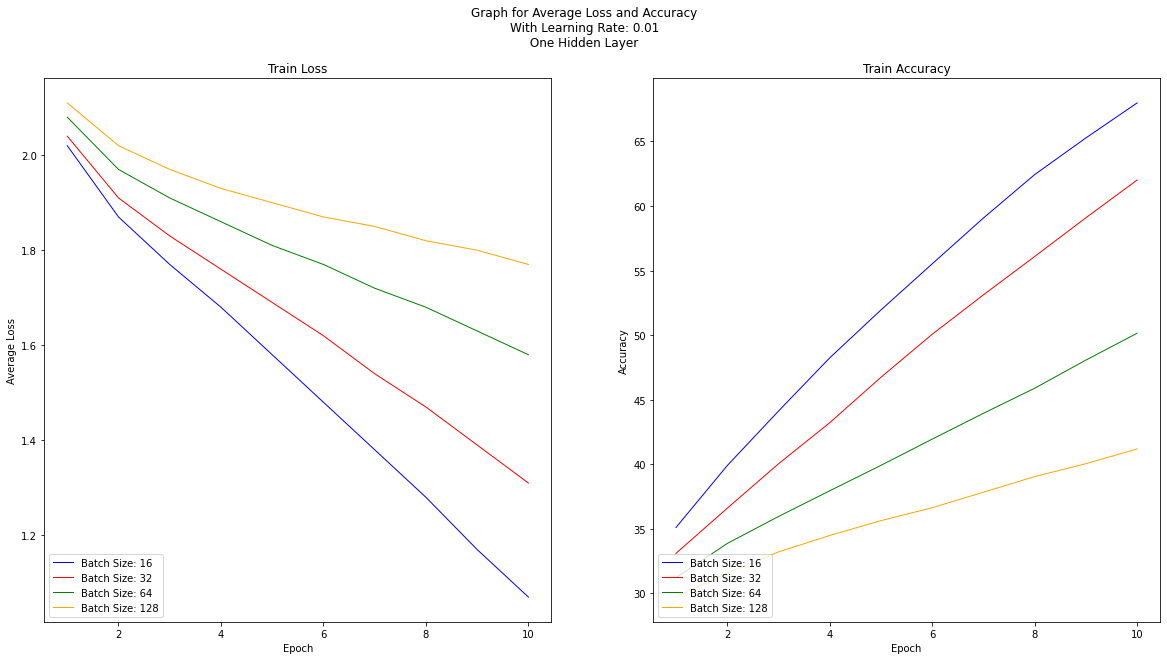

In [27]:
#lr = 0.01, Neurons: [4096, 1024, 10]
loss_16 = [2.02, 1.87, 1.77, 1.68, 1.58, 1.48, 1.38, 1.28, 1.17, 1.07]
acc_16 = [35.11, 39.90, 44.12, 48.24, 51.95, 55.52, 59.07, 62.43, 65.27, 67.98]

loss_32 = [2.04, 1.91, 1.83, 1.76, 1.69, 1.62, 1.54, 1.47, 1.39, 1.31]
acc_32 = [33.11, 36.60, 40.04, 43.22, 46.74, 50.07, 53.12, 56.09, 59.09, 62.01]

loss_64 = [2.08, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.68, 1.63, 1.58]
acc_64 = [31.22, 33.87, 35.96, 37.95, 39.92, 41.95, 43.95, 45.89, 48.07, 50.15]

loss_128 = [2.11, 2.02, 1.97, 1.93, 1.90, 1.87, 1.85, 1.82, 1.80, 1.77]
acc_128 = [29.72, 31.58, 33.22, 34.49, 35.64, 36.64, 37.84, 39.05, 40.05, 41.19]

plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " One Hidden Layer ", " Learning Rate: 0.01 ")

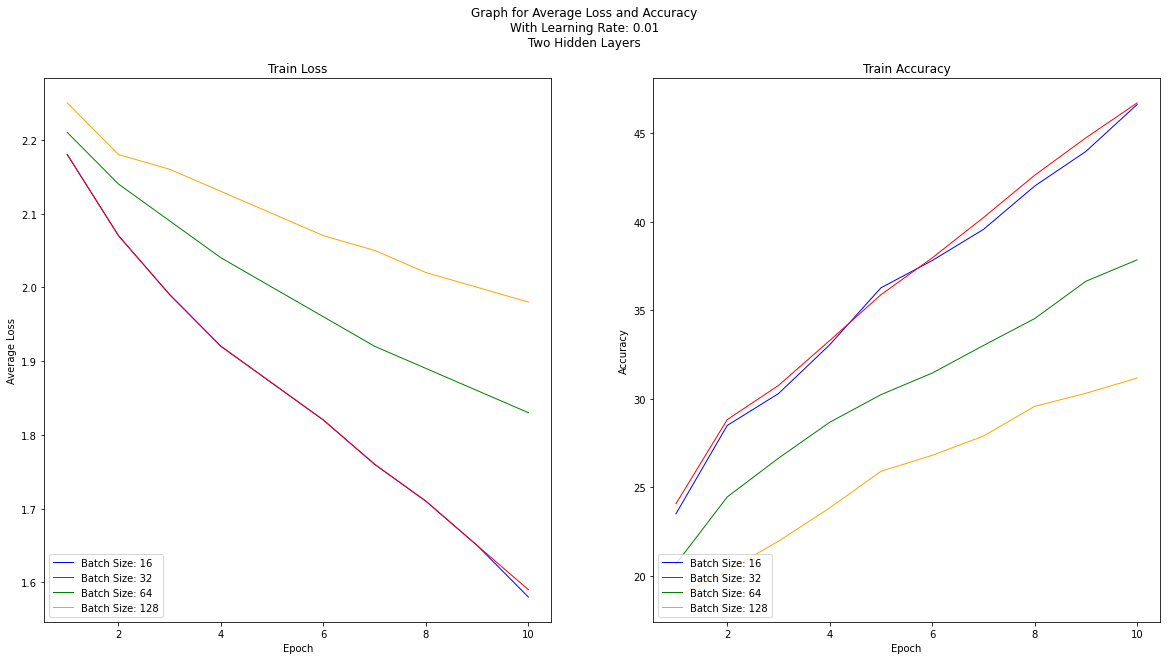

In [28]:
#lr = 0.01, Neurons: [4096, 1024, 256, 10]
loss_16 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.58]
acc_16 = [23.50, 28.49, 30.29, 33.05, 36.27, 37.81, 39.57, 42.02, 43.98, 46.63]

loss_32 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.59]
acc_32 = [24.07, 28.82, 30.75, 33.29, 35.88, 37.96, 40.24, 42.63, 44.75, 46.72]

loss_64 = [2.21, 2.14, 2.09, 2.04, 2.00, 1.96, 1.92, 1.89, 1.86, 1.83]
acc_64 = [20.66, 24.45, 26.64, 28.67, 30.23, 31.45, 33.01, 34.53, 36.64, 37.85]

loss_128 = [2.25, 2.18, 2.16, 2.13, 2.10, 2.07, 2.05, 2.02, 2.00, 1.98]
acc_128 = [18.79, 20.27, 21.95, 23.83, 25.90, 26.80, 27.89, 29.57, 30.31, 31.17]
plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " Two Hidden Layers ", " Learning Rate: 0.01 ")

### Learning Rate

In [29]:
from matplotlib import pyplot as plt
def plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02, layer, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    plt.suptitle("Graph for Average Loss and Accuracy" + "\n" + "With "+ lr)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_005, color="blue", label="Learning Rate: 0.005", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_01, color="red", label="Learning Rate: 0.01", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_02, color="green", label="Learning Rate: 0.02", linewidth=1, linestyle="-")


    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_005, color="blue", label="Learning Rate: 0.005", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_01, color="red", label="Learning Rate: 0.01", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_02, color="green", label="Learning Rate: 0.02", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+layer+lr+".png")
    #plt.close()

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

The graphs below illustrate the average train loss and train accuracy results for different learning rates (0.005, 0.01, 0.02) with respect to different neural network structures like single layer and multilayer neural networks. The goal is to observe the effect of learning rate on our models. 

When we examine the graphics, we can see that the best model in single layer architecture is established when the learning rate is equal to 0.005. However, we observe that the best model in one-layer and two-layer architecture is established when the learning rate is equal to 0.02.

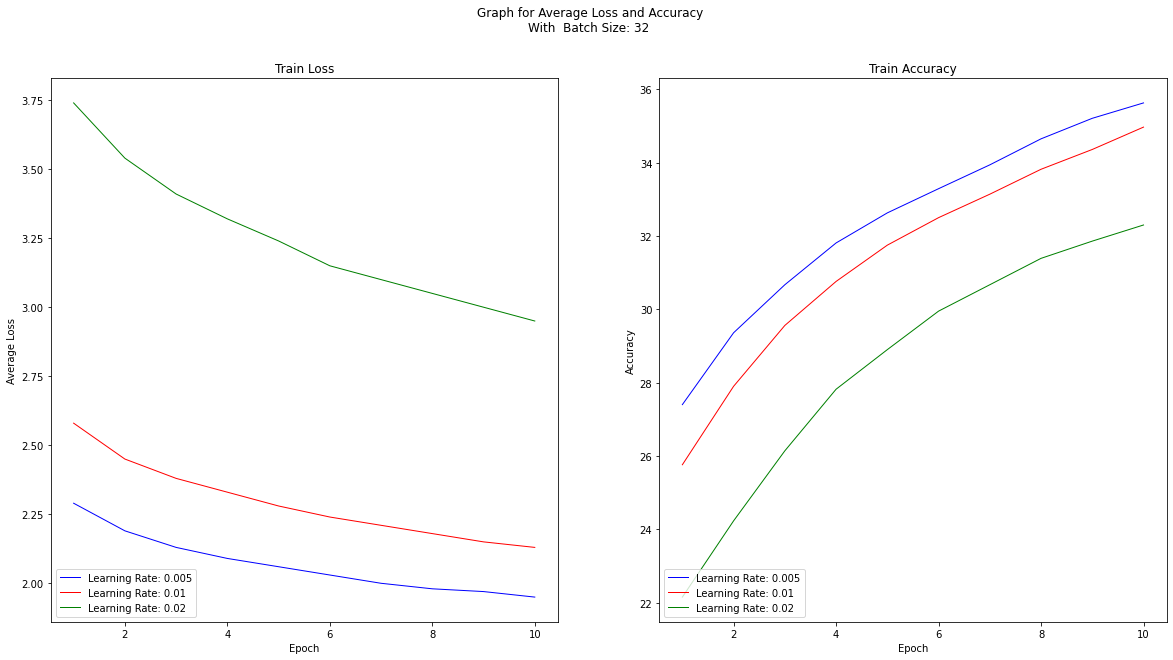

In [30]:
#Neurons: [4096, 10] Batch Size: 32
loss_005 = [2.29, 2.19, 2.13, 2.09, 2.06, 2.03, 2.00, 1.98, 1.97, 1.95]
acc_005 = [27.40, 29.36, 30.67, 31.81, 32.63, 33.29, 33.94, 34.65, 35.21, 35.63]

loss_01 = [2.58, 2.45, 2.38, 2.33, 2.28, 2.24, 2.21, 2.18, 2.15, 2.13]
acc_01 = [25.76, 27.90, 29.56, 30.76, 31.75, 32.50, 33.14, 33.82, 34.36, 34.97]

loss_02 = [3.74, 3.54, 3.41, 3.32, 3.24, 3.15, 3.10, 3.05, 3.00, 2.95]
acc_02 = [22.15, 24.23, 26.14, 27.82, 28.90, 29.95, 30.67, 31.39, 31.86, 32.30]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Single Layer ", " Batch Size: 32 ")

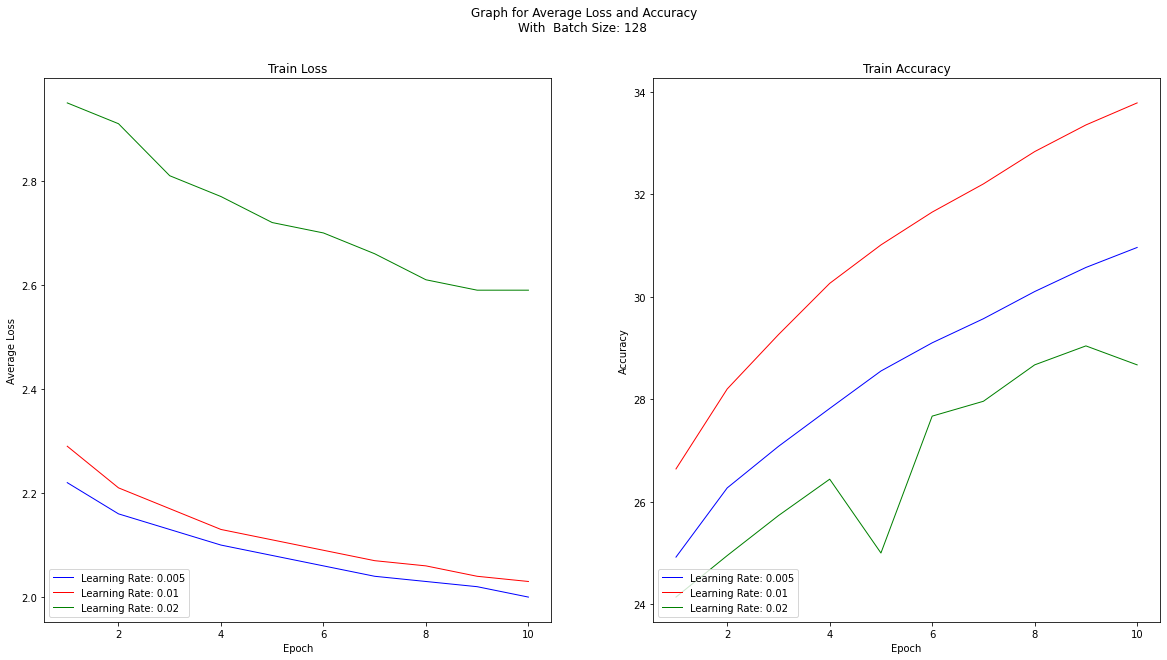

In [31]:
# Neurons: [4096, 10] Batch Size: 128 
loss_005 = [2.22, 2.16, 2.13, 2.10, 2.08, 2.06, 2.04, 2.03, 2.02, 2.00]
acc_005 = [24.92, 26.27, 27.08, 27.82, 28.55, 29.10, 29.57, 30.10, 30.57, 30.96]

loss_01 = [2.29, 2.21, 2.17, 2.13, 2.11, 2.09, 2.07, 2.06, 2.04, 2.03]
acc_01 = [26.64, 28.20, 29.26, 30.26, 31.01, 31.65, 32.20, 32.83, 33.35, 33.78]

loss_02 = [2.95, 2.91, 2.81, 2.77, 2.72, 2.70, 2.66, 2.61, 2.59, 2.59]
acc_02 = [24.14, 24.95, 25.73, 26.44, 25.00, 27.67, 27.96, 28.67, 29.04, 28.67]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Single Layer ", " Batch Size: 128 ")

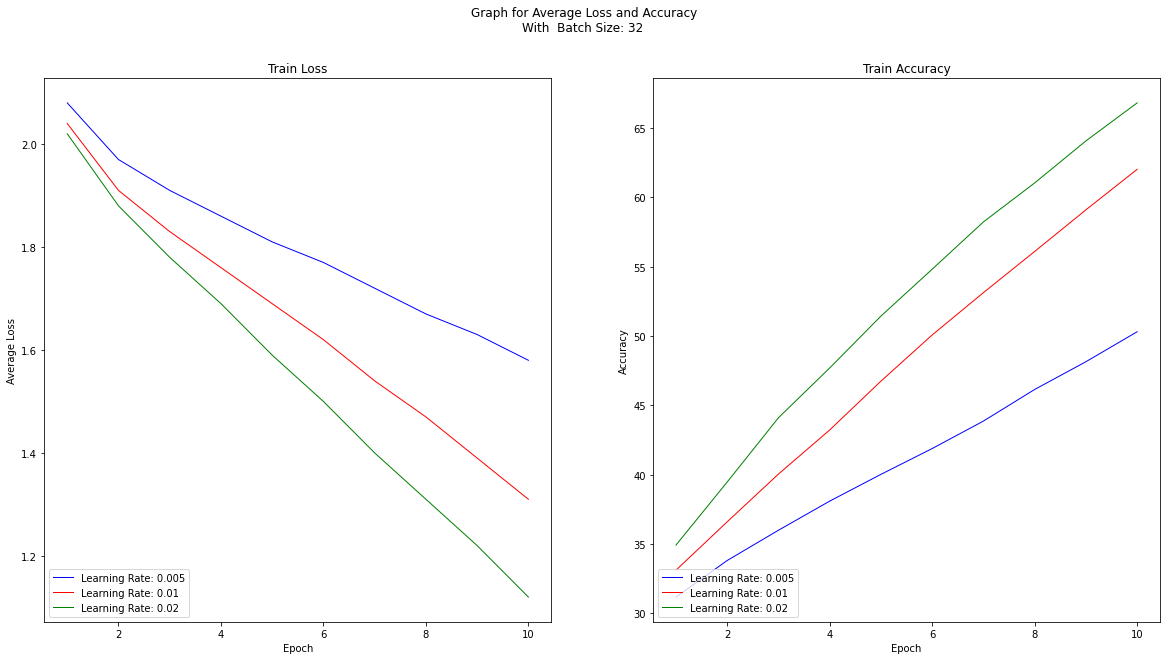

In [32]:
# Neurons: [4096, 1024, 10] Batch Size: 32
loss_005 = [2.08, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.67, 1.63, 1.58]
acc_005 = [31.17, 33.81, 35.99, 38.09, 40.02, 41.88, 43.86, 46.14, 48.14, 50.30]

loss_01 = [2.04, 1.91, 1.83, 1.76, 1.69, 1.62, 1.54, 1.47, 1.39, 1.31]
acc_01 = [33.11, 36.60, 40.04, 43.22, 46.74, 50.07, 53.12, 56.09, 59.09, 62.01]

loss_02 = [2.02, 1.88, 1.78, 1.69, 1.59, 1.50, 1.40, 1.31, 1.22, 1.12]
acc_02 = [34.92, 39.47, 44.10, 47.69, 51.43, 54.81, 58.22, 61.03, 64.06, 66.80]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," One Hidden Layer ", " Batch Size: 32 ")

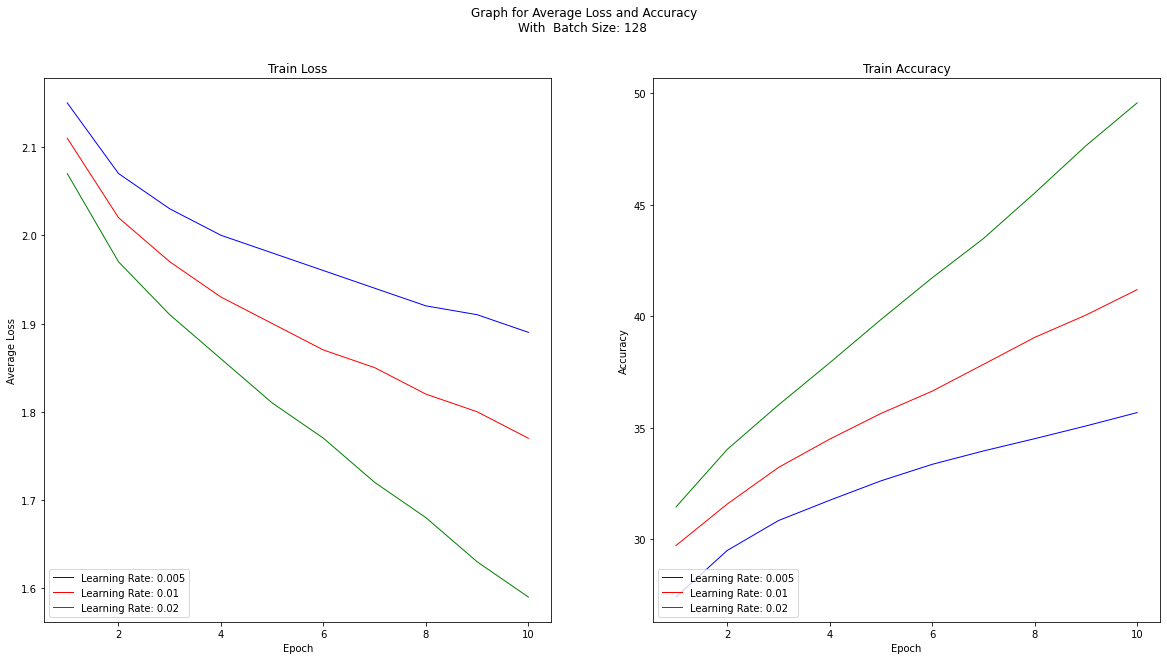

In [33]:
# Neurons: [4096, 1024, 10] Batch Size: 128

loss_005 = [2.15, 2.07, 2.03, 2.00, 1.98, 1.96, 1.94, 1.92, 1.91, 1.89]
acc_005 = [27.41, 29.50, 30.84, 31.75, 32.62, 33.36, 33.96, 34.51, 35.08, 35.68]

loss_01 = [2.11, 2.02, 1.97, 1.93, 1.90, 1.87, 1.85, 1.82, 1.80, 1.77]
acc_01 = [29.72, 31.58, 33.22, 34.49, 35.64, 36.64, 37.84, 39.05, 40.05, 41.19]

loss_02 = [2.07, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.68, 1.63, 1.59]
acc_02 = [31.45, 34.03, 36.02, 37.91, 39.85, 41.72, 43.48, 45.52, 47.64, 49.56]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," One Hidden Layer ", " Batch Size: 128 ")

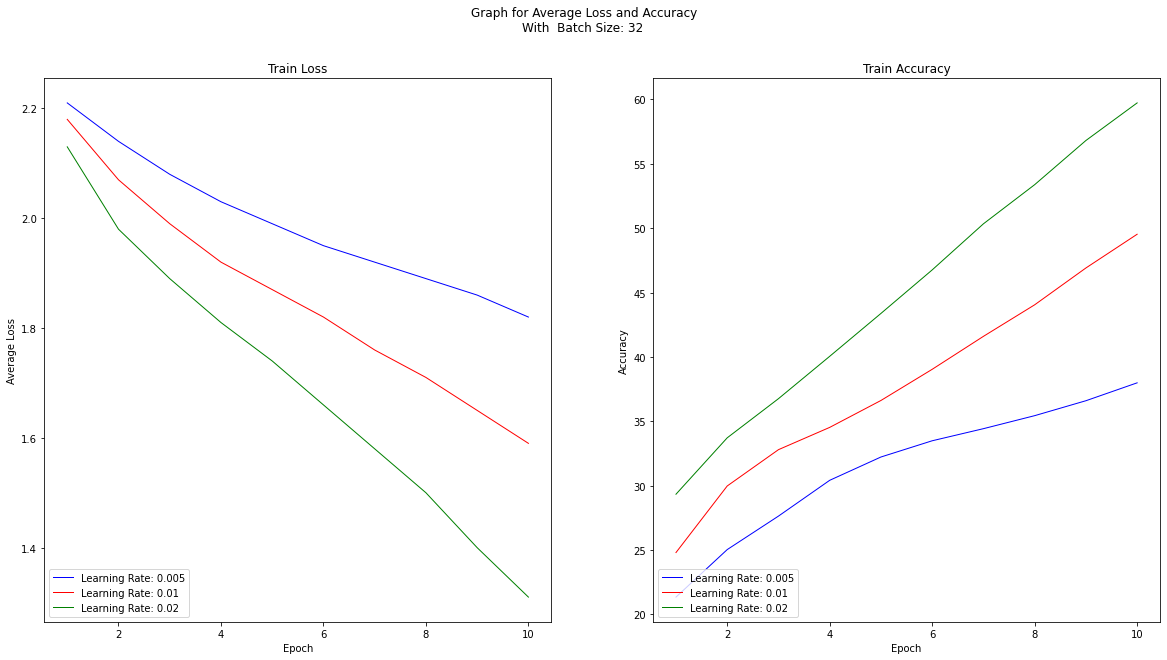

In [34]:
# Neurons: [4096, 1024, 256, 10] Batch Size: 32

loss_005 = [2.21, 2.14, 2.08, 2.03, 1.99, 1.95, 1.92, 1.89, 1.86, 1.82]
acc_005 = [21.35, 25.04, 27.64, 30.42, 32.23, 33.49, 34.43, 35.44, 36.60, 37.99]

loss_01 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.59]
acc_01 = [24.81, 29.98, 32.80, 34.53, 36.62, 39.04, 41.60, 44.05, 46.91, 49.53]

loss_02 = [2.13, 1.98, 1.89, 1.81, 1.74, 1.66, 1.58, 1.50, 1.40, 1.31]
acc_02 = [29.34, 33.72, 36.76, 40.05, 43.38, 46.76, 50.34, 53.38, 56.81, 59.73]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Two Hidden Layers ", " Batch Size: 32 ")

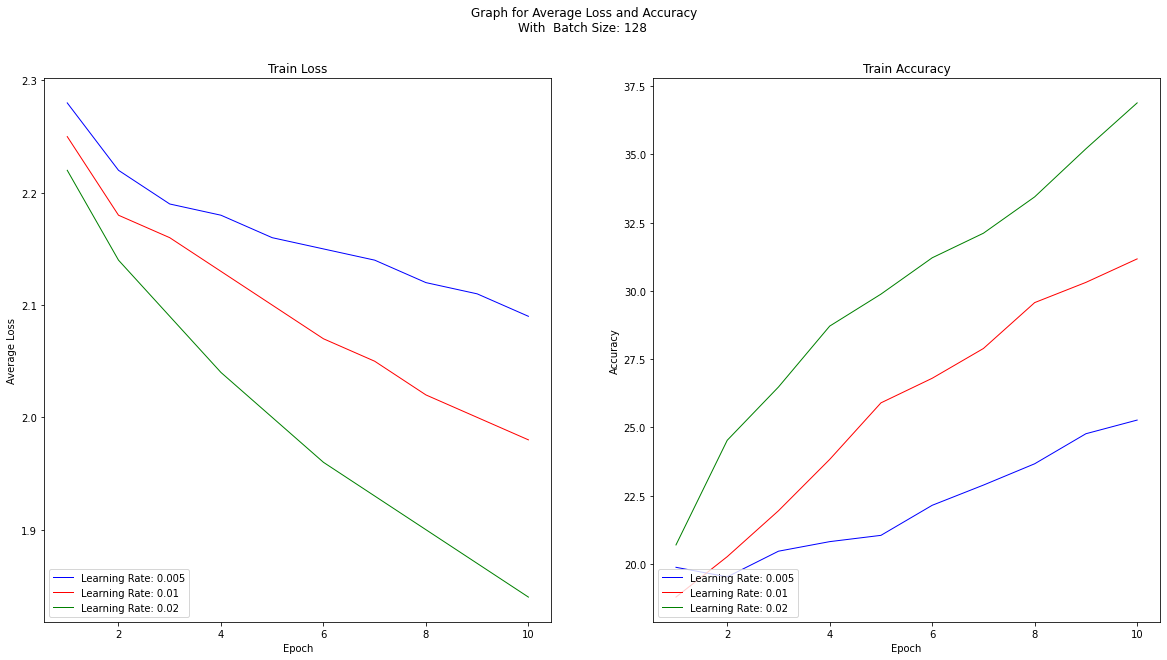

In [35]:
# Neurons: [4096, 1024, 256, 10] Batch Size: 128

loss_005 = [2.28, 2.22, 2.19, 2.18, 2.16, 2.15, 2.14, 2.12, 2.11, 2.09]
acc_005 = [19.88, 19.53, 20.47, 20.82, 21.05, 22.15, 22.89, 23.67, 24.77, 25.27]

loss_01 = [2.25, 2.18, 2.16, 2.13, 2.10, 2.07, 2.05, 2.02, 2.00, 1.98]
acc_01 = [18.79, 20.27, 21.95, 23.83, 25.90, 26.80, 27.89, 29.57, 30.31, 31.17]

loss_02 = [2.22, 2.14, 2.09, 2.04, 2.00, 1.96, 1.93, 1.90, 1.87, 1.84]
acc_02 = [20.70, 24.53, 26.48, 28.71, 29.88, 31.21, 32.11, 33.44, 35.20, 36.88]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Two Hidden Layers ", " Batch Size: 128 ")

### Hidden Layer

In [36]:
from matplotlib import pyplot as plt
def plot_graph_layer(loss_single, loss_one_hidden, loss_two_hidden, acc_single, acc_one_hidden, acc_two_hidden, batch, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    #plt.suptitle(batchtype+ lr + layer)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_single, color="blue", label="Single Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_one_hidden, color="red", label="One Hidden Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_two_hidden, color="green", label="Two Hidden Layers", linewidth=1, linestyle="-")


    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_single, color="blue", label="Single Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_one_hidden, color="red", label="One Hidden Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_two_hidden, color="green", label="Two Hidden Layers", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+batch+lr+".png")
    #plt.close()

If a neural network has only an input and output layer, it is called a single layer neural network. When this is the case, there may be some problems in learning. Because single layer neural network is not a good machine learning method for linearly non-separable data .  But we use the multilayer neural network we will solve this problem.
When using multilayer , a hidden layer and node size important. Because if we use a few hidden layers, we may encounter errors such as overfits, and if we use multiple layers we may encounter errors such as overflow. 

The graph below shows the average train loss and train accuracy results for different neural network structures such as single-layer and multi-layer neural networks, with the batch size equal to 128 and the learning rate equal to 0.02. The aim is to observe the effect of the number of hidden layers on our models. We see that the best average loss and accuracy is established with a one-hidden layer network.

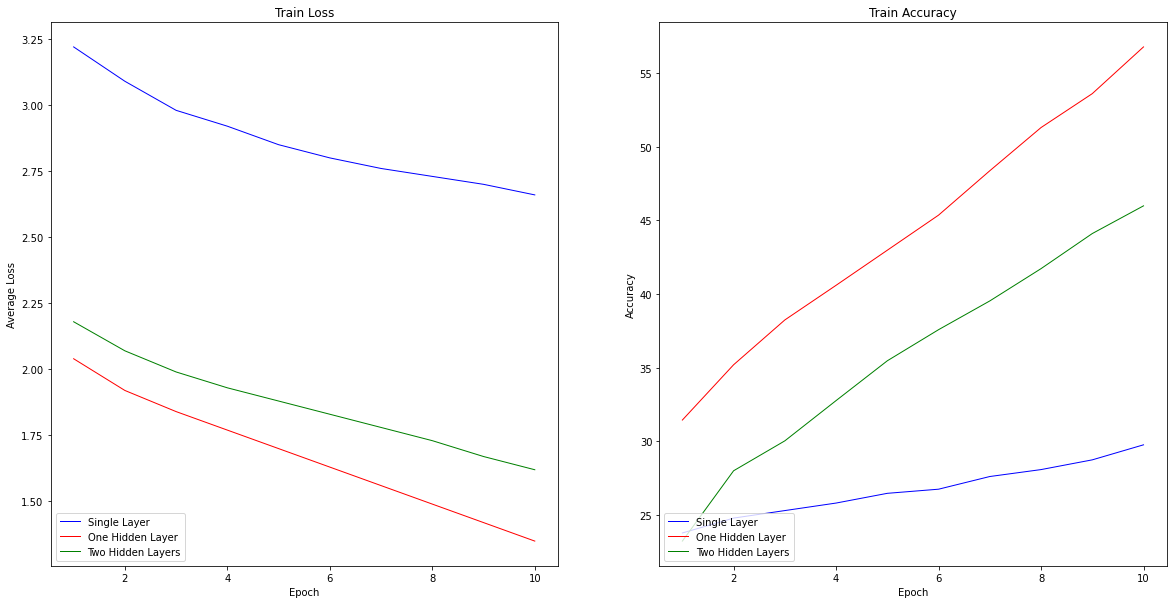

In [37]:
#batch size: 128 lr: 0.02
loss_single = [3.22, 3.09, 2.98, 2.92, 2.85, 2.80, 2.76, 2.73, 2.70, 2.66]
acc_single = [23.79, 24.80, 25.31, 25.82, 26.48, 26.76, 27.62, 28.09, 28.75, 29.77]

loss_one_hidden = [2.04, 1.92, 1.84, 1.77, 1.70, 1.63, 1.56, 1.49, 1.42, 1.35]
acc_one_hidden = [31.45, 35.20, 38.24, 40.59, 42.97, 45.35, 48.36, 51.29, 53.59, 56.76]

loss_two_hidden = [2.18, 2.07, 1.99, 1.93, 1.88, 1.83, 1.78, 1.73, 1.67, 1.62]
acc_two_hidden = [23.24, 28.01, 30.04, 32.77, 35.47, 37.58, 39.53, 41.72, 44.10, 45.98]

plot_graph_layer(loss_single, loss_one_hidden, loss_two_hidden, acc_single, acc_one_hidden, acc_two_hidden, " Batch Size: 128 ", "Lr: 0.02" )

### Test Accuracy Results & Conclusions

The tables below illustrate the test accuracy results for different learning rates in the range __0.005 to 0.02__ with respect to different neural network structures like single layer and multilayer neural networks. We pick batch size fixed in each table. Thus, the first table displays the results for __batch_size__ = 16, and the last one shows the results for batch_size=128. When calculating the test accuracies, we pick the best model in epoch according to its train accuracy and test the model with that particular one. Hence, in this table we prefer include epochs, instead we illustrate test accuracy results for each model with different training parameters.

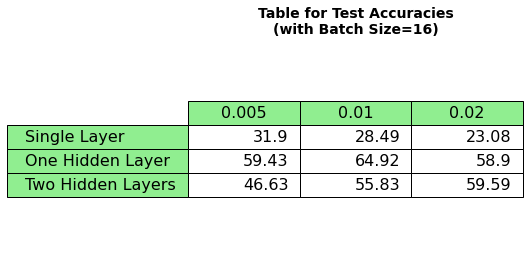

In [43]:
draw_table([[31.90, 28.49, 23.08], [59.43, 64.92, 58.90], [46.63, 55.83, 59.59]] ,[0.005, 0.01, 0.02], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Test Accuracies", "with Batch Size=16", "lightgreen")

From the table above, it can be concluded that the best accuracy is achieved when the one hidden layer architecture is applied with the learning rate = 0.01. The best accuracy value for the batch_size 16 is __64.92__. On the other hand, the worst accuracy result is obtained when the single layer architecture is applied with the learning rate = 0.02. The worst accuracy value for the batch_size = 16 is __23.08__.

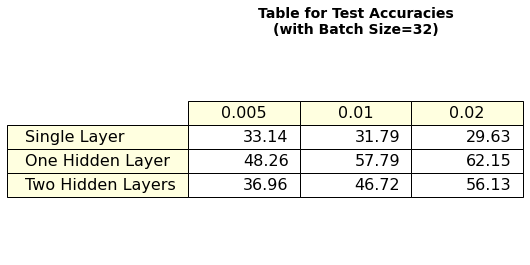

In [42]:
draw_table([[33.14, 31.79, 29.63], [48.26, 57.79, 62.15], [36.96, 46.72, 56.13]] ,[0.005, 0.01, 0.02], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Test Accuracies", "with Batch Size=32", "lightyellow")

In the table above, it can be seen that the best result is achieved when one hidden layer architecture is applied with the learning rate = 0.02. On the other hand, the worst accuracy result is obtained when single layer architecture is applied with the learning rate = 0.02. The best accuracy for batch_size = 32 is __62.15__ and the worst one is __29.63__.  

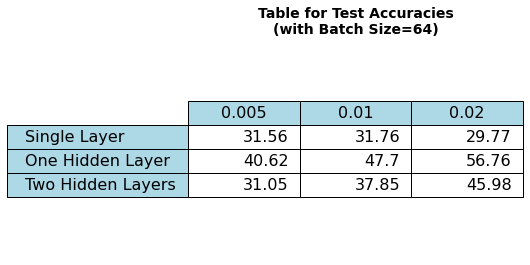

In [41]:
draw_table([[31.56, 31.76, 29.77], [40.62, 47.70, 56.76], [31.05, 37.85, 45.98]] ,[0.005, 0.01, 0.02], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Test Accuracies", "with Batch Size=64", "lightblue")

In the table above, it can be seen that the best result is achieved when one hidden layer architecture is applied with the learning rate = 0.02. On the other hand, the worst accuracy result is obtained when single layer architecture is applied with the learning rate = 0.02. The best accuracy for batch_size = 32 is __59.76__ and the worst one is __29.77__. It can be seen that the best and worst models for batch_size = 64 and 32 are obtained with the same parameters.

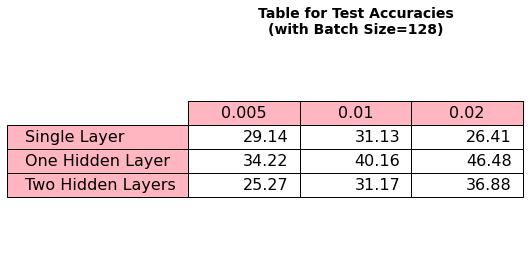

In [44]:
draw_table([[29.14, 31.13, 26.41], [34.22, 40.16, 46.48], [25.27, 31.17, 36.88]] ,[0.005, 0.01, 0.02], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Test Accuracies", "with Batch Size=128", "lightpink")

From the table above, it can be concluded that the best accuracy is achieved when the one hidden layer architecture is applied with the learning rate = 0.01. The best accuracy value for the batch_size 16 is __46.48__. On the other hand, the worst accuracy result is obtained when the two hidden layer architecture is applied with the learning rate = 0.005. The worst accuracy value for the batch_size = 16 is __25.27__.

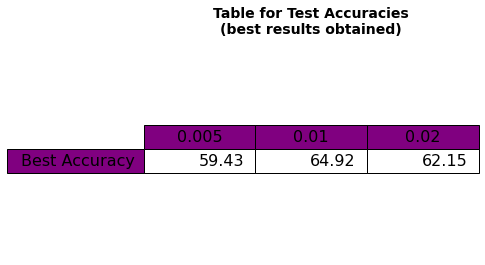

In [46]:
draw_table([[59.43, 64.92, 62.15]] ,[0.005, 0.01, 0.02], ["Best Accuracy"], "Table for Test Accuracies", "best results obtained", "purple")

When we look at the best accuracies, we can see that for learning rate = 16, the best accuracy is __59.42__, for learning rate = 32,  the best accuracy is __64.92__, and lastly for learning rate = 32,  the best accuracy is __62.15__. The best accuracy values for learning rates 0.005 and 0.01 comes from the table for batch_size = 16, and the value for learning rate = 0.02 comes from the batch_size = 32. Thus, __it seems like for models trained with smaller batch sizes, we achieved better accuracy values__. As we mentioned previously, using larger batch sizes would allow us to parallelize computations to a greater degree, since we could split up the training examples between different worker nodes. This in turn could significantly speed up model training. However, larger batch sizes, while able to achieve similar training error as smaller batch sizes, tend to generalize worse to test data. So, our algorithm may generalize the data worse when we apply bigger batch sizes and it may result in worse accuracy values.

Furthermore, the __best value among all test accuracy results is achieved with the parameters learning rate = 0.01, batch_size = 16 on one hidden layer neural network architecture__. It can be seen from the tables above, generally the best results are obtained on the one hidden layer architecture.

### Train Accuracy Results and Conclusions

The tables below illustrate the train accuracy results for different batch sizes in the range of 16 to 128 (namely 16, 32, 64, 128) with respect to different neural network structures like single layer and multilayer neural networks. We pick the learning rate fixed in each table. Thus, the first table displays the results for learning rate = 0.005, and the last one shows the results for learning rate = 0.2.

In the previous chapter of this report, we illustrated line graphs for train accuracies in each epoch that's why in this part we prefer not to include epochs, instead we use the values of best train accuracy achieved in each model (usually appear on the last epoch). Furthermore, in order to able to represent results in different variations, we pick learning rate fixed this part.

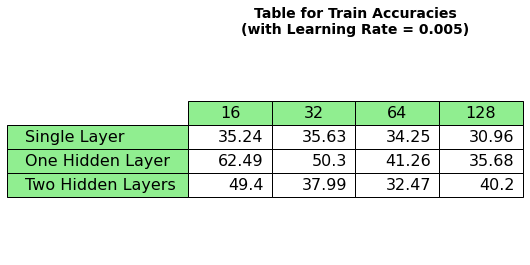

In [5]:
draw_table([[35.24, 35.63, 34.25, 30.96], [62.49,  50.30, 41.26, 35.68], [49.40, 37.99, 32.47, 40.2]] ,[16, 32, 64, 128], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Train Accuracies", "with Learning Rate = 0.005", "lightgreen")

From the table above, it can be stated that the best tranining accuracy is achieved with the one layer neural network architecture and 16 batch size. It is important here to emphasize that the learning parameter is fixed for all cells. Therefore, the best tranining accuracy achieved with these parameters is __62.49__.

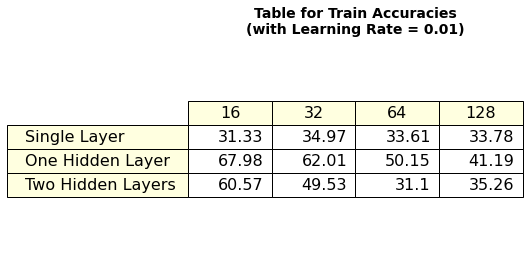

In [12]:
draw_table([[31.33, 34.97, 33.61, 33.78], [67.98, 62.01, 50.15, 41.19], [60.57, 49.53, 31.1, 35.26]] ,[16, 32, 64, 128], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Train Accuracies", "with Learning Rate = 0.01", "lightyellow")

In the table for learning rate = 0.01, it can be seen that generally the accuracy value decreases as batch size is increased. The best acccuracy result is achieved with batch size = 16 on one hidden layer neural network architecture, which is __67.98__. On the other hand, the worst accuracy value appeared as __31.1__ on two hidden layer architecture with the parameter batch_size = 64. 

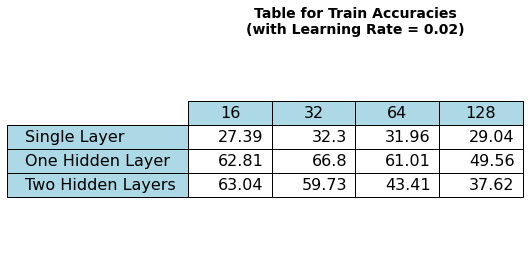

In [10]:
draw_table([[27.39, 32.30, 31.96, 29.04], [62.81, 66.80, 61.01, 49.56], [63.04, 59.73, 43.41, 37.62]] ,[16, 32, 64, 128], ["Single Layer", "One Hidden Layer", "Two Hidden Layers"], "Table for Train Accuracies", "with Learning Rate = 0.02", "lightblue")

For the fixed parameter learning rate = 0.02, the best accuracy value achieved is __66.8__ with batch size = 16 on one hidden layer architecture, whereas the worst accuracy is __27.39__ with the batch size = 16 on single layer architecture.

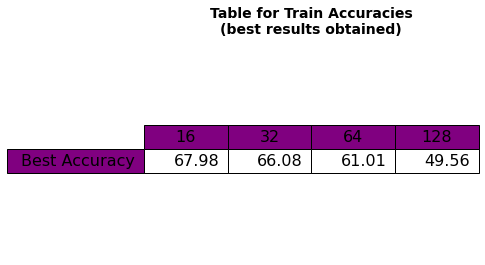

In [13]:
draw_table([[67.98, 66.08, 61.01, 49.56]] ,[16, 32, 64, 128], ["Best Accuracy"], "Table for Train Accuracies", "best results obtained", "purple")

To sum up, similar to the test accuracy results, it seems like the __accuracy decreases as the batch size increases__. Also, when we compare the results we obtain on the test and train phase, the accuracy on training data is slightly greater than testing data. 

Furthermore, the __best value among all train accuracy results is achieved with the parameters learning rate = 0.01, batch_size = 16 on one hidden layer neural network architecture__, which is the same parameters obtained on the test accuracies. It can be seen from the tables above, generally the best results are obtained on the one hidden layer architecture.

## PART 2: Convolutional Neural Network

The higher performance of convolutional neural networks with picture, speech, or audio signal inputs sets them apart from other neural networks. CNNs have three main types of layers, which are: convolutional layer, pooling layer and fully-connected (FC) layer.

A convolutional network's first layer is the convolutional layer. While further convolutional layers or pooling layers can be added after convolutional layers, the fully-connected layer is the last layer. The CNN becomes more complicated with each layer, detecting larger areas of the image. Earlier layers concentrate on basic elements like colors and borders. As the visual data travels through the CNN layers, it begins to distinguish larger elements or features of the item, eventually identifying the target object.

In this part, we builded a convolutional neural network(CNN) with PyTorch to classify images into different animal classes. By the end of this assignment, we become familiar with PyTorch, CNNs, padding, stride, max pooling and we are able to build own CNN model for image classification. 

In [47]:
#import modules 

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from glob import glob

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

from torchvision import transforms
from torchvision.models.vgg import vgg19_bn

In [48]:
def provide_determinism(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
class CNNDataset(Dataset):
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
        "dog": "cane",
        "horse": "cavallo",
        "elephant" : "elefante",
        "butterfly": "farfalla",
        "chicken": "gallina",
        "cat": "gatto",
        "cow": "mucca",
        "sheep": "pecora",
        "spider": "ragno",
        "squirrel": "scoiattolo"
    }

    def __init__(self, data_parent='data/'):
        super().__init__()

        self.data_path = os.path.join(data_parent, 'raw-img')

        self.org_names = list(self.translate.keys())[:10]
        self.eng_names = list(self.translate.keys())[10:]

        
        #translate the class names from Italian to English
        self.data_paths = []
        for i in range(len(self.org_names)):
            img_paths = glob(
                os.path.join(self.data_path, self.org_names[i], '*')
            )
            
            self.data_paths.extend(list(zip(img_paths, [i] * len(img_paths))))
        
        #transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            ),
        ])

    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        img_path, label = self.data_paths[index]
        img = Image.open(img_path).convert('RGB')

        x = self.transform(img)

        return x, label


For training our model, we need a dataset which has images and label attached to it. Our dataset consist of 10 types of images and they stored in corresponding folders.

To prepare a dataset from such a structure, PyTorch provides Transform which makes the task easy for us to prepare the dataset. We simply have to pass the directory of our data to it and it provides the dataset which we can use to train the model.

The torchvision.transforms module provides various functionality to preprocess the images, here first we resize the image for (224*224) shape and then transforms them into tensors.

So our first image in the dataset has a shape (3, 224, 224) which means the image has 3 channels (RGB), height 224, and width 224. 

In [50]:
def cnn_train(train_set, test_set, only_train_fc=False):
    train_loader = DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_set,
        batch_size=128,
        shuffle=False,
        pin_memory=True,
    )

    # VGG is 1000 class network, changing the last layer is a solution
    # but it would change weight distribution so I am not changing it.
    # Model should learn to output only the first 10 class.
    model = vgg19_bn(pretrained=True).to(device)
    
    if only_train_fc:
        for param in model.parameters():
            param.requires_grad = False
        
        # Train only last two linear layers
        for param in model.classifier[3].parameters():
            param.requires_grad = True
        for param in model.classifier[6].parameters():
            param.requires_grad = True
    
    lr = 0.0002 if only_train_fc else 0.0005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    best_acc = -100
    for epoch in range(1, 11):
        model.train()
        
        train_correct = 0
        loss_acc = 0
        epoch_tqdm = tqdm(
            train_loader, total=len(train_loader), leave=True, desc="Train"
        )
        for images, labels in epoch_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad(set_to_none=True)

            output = model(images)
            output = output.squeeze(1)
            loss = criterion(output, labels)
            
            loss.backward()

            optimizer.step()

            loss_acc += loss.item()

            output = output.argmax(dim=1)
            train_correct += sum(output==labels)

        optimizer.zero_grad(set_to_none=True)

        model.eval()

        test_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                output = output.squeeze(1)
                output = output.argmax(dim=1)

                test_correct += sum(output==labels)

        test_acc = (float(test_correct) / len(test_set)) * 100

        if test_acc >= best_acc:
            torch.save(
                {'model': model},
                'vgg_' + ('fc' if only_train_fc else 'full') + '.pth'
            )

            best_acc = test_acc

        print(
            f"Epoch {str(epoch).zfill(3)} | "
            + f"Best Test Acc. = {best_acc:.2f}%"      # Best test. acc.
            + f", Last Test Acc. = {test_acc:.2f}%"     # Last test. acc.
        )
        
        scheduler.step()
    
    return model

We can not pass the whole dataset into our model to train it, because our memory size is fixed and there is a high chance that our training data exceed the memory capacity of CPU or GPU, so we split the dataset into batches and instead of training the model on whole in a single phase.  For example, the batch size can be 16, 32, 64, 128 etc.
Here we take batches of size 128  from the data for training. To randomly split the images into training, PyTorch provides random_split().
The data is divided into batches using the PyTorch DataLoader class. We create two objects train_loader and test_loader for training and validation data respectively by giving parameters training data and batch size into the DataLoader Class.

In order to do these clustering operations, we had to extract features from the train set we have. We used VGG19 feature extraction methods to do this. VGG is basically a convolutional neural network model. The numbers 19 represent how many convolutional layers there are in the model. This structure is generally used for image object classification(Rashid, Khan, Alhaisoni, Wang, Naqvi, Rehman, and Saba, 2020). In our study, we tried to use these VGG layers for both object-based classification and style-based classification. 

For this part, VGG -19, a type of CNN model is used, which is 19 weight layers consisting of 16 convolutional layers with 3 fully connected layers and the same 5 pooling layers.
The input is a 224 * 224 RGB image to VGG based convNet. The pre-processing layer takes the RGB image with pixel values in the range 0–255 and subtracts the mean image values computed over the entire ImageNet training collection. After pre-processing, the input images are passed through layers of weight. The training images are processed through a stack of convolutional layers.

#### Input Layer
The input layer consists of the raw image (resized to 224 × 224 pixels) in three channels.

#### Convolution Layer
The convolution layer is the first layer that handles the image and the main building block of CNN. As it is known, visuals are actually matrices consisting of pixels with certain values. In the convolution layer, a filter smaller than the original image size hovers over the image and tries to capture certain features from these images.

#### Max-pooling layer
The pooling layer also aims to reduce the dimensionality. In this way, both the required processing power is reduced and the captured unnecessary features are ignored and more important features are fo- cused on. In the pooling layer, which has a filter like the convolutional layer, this filter again hovers over the image. For max pooling, the aim is to get the largest value in the area covered by the filter. In this way, the size is reduced and the important features remain in our hands.

#### Fully connected layer
In the fully connected layer, our visual that passes through the convolutional layer and the pooling layer several times and is in matrix form is turned into a flat vector.

#### Softmax Layer
The output softmax layer is the layer that implements the softmax function by using the score values from the fully connected layer. Softmax function generates a probability- based loss value using the score values generated by the artificial neural network. Converting to probability value is done with the maximum likelihood function. 

In [51]:
def cnn_test(model, test_set):
    test_loader = DataLoader(
        test_set,
        batch_size=128,
        shuffle=False,
        pin_memory=True
    )
    
    model.eval()
    
    conf_mat = torch.zeros(10, 10)
    test_correct = 0
    with torch.no_grad():
        epoch_tqdm = tqdm(
            test_loader, total=len(test_loader), leave=True, desc="Test"
        )
        for images, labels in epoch_tqdm:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            output = output.squeeze(1)
            output = output.argmax(dim=1)
            
            for t, p in zip(labels.view(-1), output.view(-1)):
                conf_mat[t.long(), p.long()] += 1

            test_correct += sum(output==labels)

    test_acc = (float(test_correct) / len(test_set)) * 100
    
    print(f"Test Acc. = {test_acc:.2f}%")
    
    print("Confusion matrix:")
    print(conf_mat)

In [53]:
def conv_network():
    provide_determinism(123)

    dataset = CNNDataset()

    test_set_size = len(dataset)//10
    train_set_size = len(dataset)-test_set_size

    train_set, test_set = torch.utils.data.random_split(
        dataset, [train_set_size, test_set_size]
    )
    
    model_fc = cnn_train(train_set, test_set, only_train_fc=True)
    cnn_test(model_fc, test_set)

    model_full = cnn_train(train_set, test_set, only_train_fc=False)
    cnn_test(model_full, test_set)


### Results for Part 2 and Comparison with Part 1

In [ ]:
Test Acc. = 98.85%
Confusion matrix:
tensor([[482.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.],
        [  0., 256.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.],
        [  3.,   0., 117.,   0.,   0.,   0.,   4.,   0.,   0.,   0.],
        [  0.,   0.,   0., 196.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2., 290.,   0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0., 163.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0.,   0.,   0., 180.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   1., 184.,   0.,   0.],
        [  0.,   0.,   0.,   4.,   0.,   0.,   0.,   0., 526.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0., 193.]])

In part 2, we achieved way more better results compared to part 1. The __accuracy achieved is 98.85__. 

### Confusion Matrix

We obtained the following confusion matrix for the part 1 (confusion matrix for the network achieved best accuracy is selected):

In [19]:
conf_mat_part_1 =\
[[346.,   6.,   7.,   9.,   9.,   6.,   5.,  11.,  63.,  10.],
 [ 40., 178.,   6.,   1.,   5.,   0.,   5.,  14.,  15.,   3.],
 [ 27.,   3.,  64.,   3.,   2.,   2.,   2.,   8.,  13.,   4.],
 [ 32.,   1.,   1., 108.,   6.,   4.,   1.,   5.,  44.,   6.],
 [ 37.,   3.,   4.,   7., 201.,   2.,   5.,  15.,  26.,  10.],
 [ 52.,   2.,   0.,   6.,   6.,  41.,   0.,   2.,  33.,  15.],
 [ 25.,   9.,   4.,   0.,   4.,   1., 106.,  21.,   8.,   4.],
 [ 23.,   3.,   2.,   5.,   3.,   1.,   9., 136.,  17.,   0.],
 [ 44.,   0.,   4.,   4.,   7.,   1.,   4.,  11., 399.,  11.],
 [ 22.,   1.,   1.,   6.,   8.,   6.,   3.,   5.,  34., 114.]]


And obtained the following confusion matrix fow the part 2:

In [91]:
conf_mat_part_2 =\
[[482.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.],
[  0., 256.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.],
[  3.,   0., 117.,   0.,   0.,   0.,   4.,   0.,   0.,   0.],
[  0.,   0.,   0., 196.,   0.,   0.,   0.,   0.,   0.,   0.],
[  0.,   0.,   0.,   2., 290.,   0.,   0.,   1.,   0.,   0.],
[  0.,   0.,   0.,   1.,   0., 163.,   0.,   0.,   0.,   0.],
[  0.,   1.,   0.,   0.,   0.,   0., 180.,   0.,   0.,   0.],
[  1.,   0.,   0.,   0.,   0.,   0.,   1., 184.,   0.,   0.],
[  0.,   0.,   0.,   4.,   0.,   0.,   0.,   0., 526.,   0.],
[  0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0., 193.]]

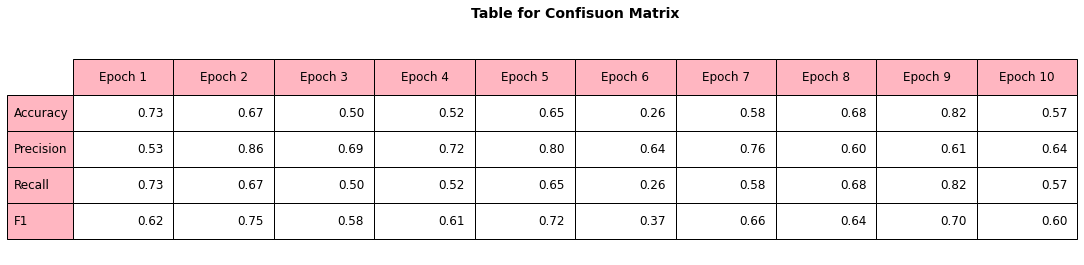

In [22]:
print_conf_mat(conf_mat_part_1)

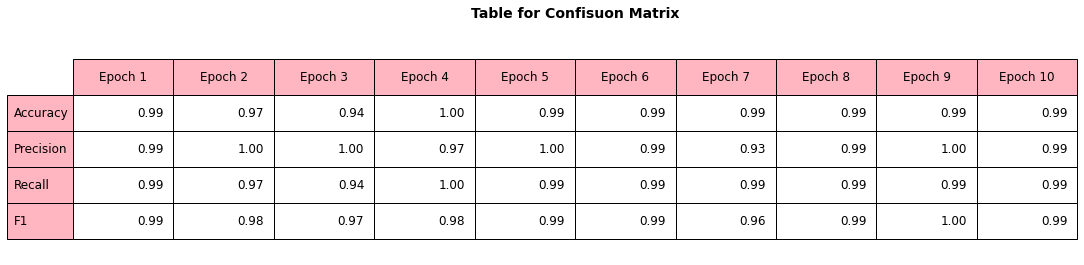

In [175]:
print_conf_mat(conf_mat_part_2)

Convolutional Neural Networks (CNNs) outperform classic neural networks on photos and videos because the convolutional layers take advantage of inherent properties of images. The inputs to simple feedforward neural networks have no order. If you shuffled all of your images in the same way, the neural network would operate just as it did when it was trained on non-shuffled images. CNN, on the other hand, takes advantage of picture local spatial coherence. Because adjacent pixels together are relevant, they can dramatically reduce the amount of operations required to process a picture by employing convolution on patches of adjacent pixels. This is also known as local connectivity. Each map is then filled with the result of convolutioning a small patch of pixels that has been slid over the entire image with a window.

The fundamental advantage of CNN over its predecessors is that it discovers essential traits without the need for human intervention. Given a large number of photos of cats and dogs, it can learn distinguishing features for each class on its own. In addition, CNN is computationally efficient.

Because the number of parameters is reduced, convolutional is more efficient. Because of the convolutional layers, they are resistant to geometrical alterations and acquire progressively complex and detailed features, making them excellent hierarchical feature extractors.

All elements of the vector inputs are treated identically by NNs. If your inputs are 10 by 1 vectors, for example, during the beginning phases of the training, all 10 inputs are treated equally. This means that during training, all 10 weights of each neuron in the first layer are updated. 

For photos, this is not a good idea. Consider what we did in this assignment, we want to segregate different animals such as dogs and cats. The ears are the most noticeable feature between cats and dogs. The ears of a cat rise up, whereas the ears of a dog tumble down.

As a result, it is preferable to take a smaller version of the larger photograph. However, there is a problem. The ears of cats can be found in many locations in various photographs of cats. Furthermore, the photographs could have been taken from various perspectives. 

As a result, we move a little camera around the huge image and send a weighted average of the new small picture's pixels to the next layer. Convolutional filters are the name for these little cameras.

As a result, only information from certain areas of the photographs is passed on. The weights of the convolutional filters are determined by training, same like the weights of the neurons in NNs. 

CNN will eventually learn to "look" at only the ears after seeing enough photographs of cats and dogs. This is why we obtained much more better results on Part 2.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
def draw_table_for_matrix(data, column_labels, row_labels, title, color):
    fig, ax =plt.subplots(1,1)
    df=pd.DataFrame(data,columns=column_labels)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values,
            colLabels=df.columns,
            rowLabels=row_labels,
            rowColours =[color] * len(row_labels),  
            colColours =[color] * len(column_labels),
            loc="center")
    table.scale(3, 3)
    table.set_fontsize(12)
    ax.axis('off')
    title = title
    ax.set_title(f'{title}\n', weight='bold', size=14, color='k')


    plt.show()

In [15]:
import numpy as np

def print_conf_mat(conf_mat):

    conf_mat = np.asarray(conf_mat)

    num_class = len(conf_mat)

    TP = conf_mat.diagonal()  # True positive
    AP = np.sum(conf_mat, axis=0)  # TP + FP
    AT = np.sum(conf_mat, axis=1)  # TP + FN

    precision = TP / AP
    recall = TP / AT
    F1 = (2 * precision * recall) / (precision + recall)
    accuracy = conf_mat.diagonal()/conf_mat.sum(1)
    
    F1 = list(map('{:.2f}'.format,F1))
    recall = list(map('{:.2f}'.format,recall))
    precision = list(map('{:.2f}'.format,precision))
    accuracy = list(map('{:.2f}'.format,accuracy))
    draw_table_for_matrix([accuracy, precision, recall, F1], ["Epoch 1", "Epoch 2", "Epoch 3", "Epoch 4", "Epoch 5", "Epoch 6", "Epoch 7", "Epoch 8", "Epoch 9", "Epoch 10"], ["Accuracy", "Precision", "Recall", "F1"], "Table for Confisuon Matrix", "lightpink")